In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #for debugging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def cls_solve(A,b,C,d):
    m,n = np.shape(A)
    p,n = np.shape(C)
    Q,R = npl.qr(np.vstack([A,C]))
    Q1 = Q[0:m,:]
    # print("q1 shape is ",Q1.shape)
    Q2 = Q[m:m+p,:]
    Qtil, Rtil = npl.qr(Q2.T)
    # print("qtil and Rtil")
    # print(Qtil.shape, Rtil.shape)
    first = np.vstack((np.matmul(np.matmul(2*Qtil.T, Q1.T),b)))
    # print("first shape")
    # print(first.shape)
    denom = first - np.vstack((2*(npl.lstsq(Rtil.T, d, rcond=None)[0])))
    k = npl.lstsq(Rtil, denom, rcond=None)[0]
    return npl.lstsq(R, np.vstack(np.matmul(Q1.T, b)) - np.matmul(Q2.T , k)/2, rcond=None)[0]
def lqe(A, B, C,G, y1, T, lam,rcond):
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]
    shape1 = (T * p, m*(T-1))
    Atil_top = np.kron(np.eye(T), C)  # This is 200 x 400
    Additional_matrix = np.random.rand(T * p, (T * p) - 6)  # Adjust dimensions to match Atil_top width

# Ensure the zeros array used in the concatenation below is of correct dimensions
    zeros_shape = (T * p, m * (T - 1))
    Atil_top_extended = np.hstack((Atil_top, Additional_matrix))

# Review dimensions for the block operation
    Atil = np.block([[Atil_top_extended, np.zeros(zeros_shape)],[np.zeros((m * (T - 1), Atil_top_extended.shape[1])), np.sqrt(lam) * np.eye(m * (T - 1))]])
    # print(Atil.shape,"#########")
    y_flat = y1.T.flatten()
    zeros_part = np.zeros(m * (T-1))
    btil = np.concatenate((y_flat, zeros_part)).reshape(-1, 1)
    # print(btil.shape)
    Ctil = np.block([
    [np.kron(np.eye(T-1), A) - np.eye(n * (T-1 ), k=n), np.kron(np.eye(T-1), G), np.kron(np.eye(T-1), B)]])
    print(Ctil.shape,"####")
    dtil = np.zeros(n * (T - 1))
    # print(dtil.shape)
    z = cls_solve(Atil, btil, Ctil, dtil)
    x_hat = [z[i * n:(i + 1) * n] for i in range(T)]
    u_hat_start_index = T * n
    u_hat_end_index = u_hat_start_index + (T)
    u_hat = [z[u_hat_start_index + i : u_hat_start_index + (i + 1) ] for i in range((T - 1) * 2)]
    w_hat_start_index = u_hat_end_index
    w_hat_end_index = w_hat_start_index + (T - 1) * p
    w_hat = [z[w_hat_start_index + i * p: w_hat_start_index + (i + 1) * p] for i in range((T - 1) * 2)]
    return x_hat,u_hat,z,w_hat,Atil,btil
### ALL THE INPUT CASES###
lambda_values = np.logspace(-4,6, num=20)
def calculate_x_next(t, x, w, A, B, G, u):
    # Base case: ensure initial state is returned as a column vector
    if t == 0:
        return np.array(x[0]).reshape(-1, 1)

    # Check if state at time t has already been calculated
    if len(x) > t:
        return np.array(x[t]).reshape(-1, 1)

    # Recursive call to get the previous state
    x_prev = calculate_x_next(t - 1, x, w, A, B, G, u)

    # Process noise and control input for the current timestep
    w_t = np.array(w[t - 1]).reshape(-1, 1)
    u_t = np.array([u[t - 1]] if t - 1 < len(u) else [0]).reshape(-1, 1)

    # State update equation
    x_t = A @ x_prev + B @ w_t + G @ u_t

    # Append the newly calculated state to the state vector list
    x.append(x_t.flatten())  # Store as a 1D array for easier handling

    # Return the new state as a column vector
    return x_t



############## Input Cases#################
T = 80
# A = np.block([[np.eye(2), np.eye(2)], [np.zeros((2, 2)), np.eye(2)]])
A = np.array([[0.9, 0, 1, 0],
              [0, 0.9, 0, 1],
              [0, 0, 0.9, 0],
              [0, 0, 0, 0.9]])
B = np.block([[np.zeros((2, 2))], [np.eye(2)]])
C = np.block([[np.eye(2), np.zeros((2, 2))]])
# C=np.eye(4)
G = np.random.rand(4, 2)
n, m, K = A.shape[0], B.shape[1], C.shape[0]
P = np.eye(m)
R = np.eye(K)*2
Q = np.eye(n)*0.5

w = [np.random.multivariate_normal(mean=np.zeros(m), cov=P) for _ in range(T)]
w_array=np.array(w)
print(w_array.shape,"w shape")
v = [np.random.multivariate_normal(mean=np.zeros(K), cov=R) for _ in range(T)]
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]
A_sin = 1
f_sin = 0.2
phi_sin = 0
m = 2        # Dimension of the multivariate Gaussian noise

sinusoidal_input = A_sin * np.sin(2 * np.pi * f_sin * np.arange(T) + phi_sin)
P = np.eye(m) # Covariance matrix P for the Gaussian noise
gaussian_noise = np.random.multivariate_normal(mean=np.zeros(m), cov=P, size=T)
sinusoidal_input = sinusoidal_input.reshape(T, 1)
u = np.hstack((sinusoidal_input, gaussian_noise[:, 0:1]))

# Reshape u to ensure each u_t is (2, 1) at each time step
u = u.reshape(T, 2, 1)
print("u.shape is")
print(len(u))
print("##############")

# Initialize the state list with the initial condition
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]

# Calculate x for eZach timestep up to T
for t in range(1, T + 1):
    # print(f'Calculating state at time {t}')  # Debug print
    calculate_x_next(t, x, w, A, B, G, u)

# Convert the list of states to a numpy array for easier handling
x_array = np.array(x)
print(x_array.shape,"x_array shape")
y = [C @ x_array[t] + v[t] for t in range(T)]
y1 = np.concatenate(y)
# rcond=-1
# type(y1)
y=np.array(y1)
print(y.shape)
# type(y)
# print(y.shape)
lam = 1e+3 # lamda value is assigned as 10^3
rcond=-1
x_hat,u_hat,z,w_hat,Atil,btil = lqe(A, B, C,G, y, T, lam,rcond)
# print(type(z))
print(z.shape,"shape of z")
x_hat=np.array(x_hat)
print(x_hat.shape,"xhat shape")
u_hat=np.array(u_hat)
print(type(u_hat))
# print(u_hat)
print(u_hat.shape,"uhat shape")

print("##########")
print(len(w_hat),"w_hat shape")
# print(u_hat)

(80, 2) w shape
u.shape is
80
##############


array([[-0.26880924],
       [-0.09348842],
       [ 0.24642764],
       [ 0.55304881]])

array([[ 0.12562642],
       [ 1.06388371],
       [-1.94726734],
       [-0.80413017]])

array([[-1.60653675],
       [ 1.22034252],
       [-0.26295422],
       [ 0.85269912]])

array([[-1.90186945],
       [ 1.04252326],
       [-3.80570792],
       [ 0.04646676]])

array([[-5.82906993],
       [-0.48223199],
       [-5.31966218],
       [-0.55271254]])

array([[-10.55313966],
       [ -0.92867091],
       [ -5.29335392],
       [ -2.27877718]])

array([[-14.57203498],
       [ -2.07106419],
       [ -3.471747  ],
       [ -1.18974424]])

array([[-16.40372972],
       [ -2.19181845],
       [ -2.77580857],
       [  0.49615161]])

array([[-17.67685916],
       [ -2.13173308],
       [ -2.22542639],
       [  0.8915671 ]])

array([[-18.28160968],
       [ -1.74041125],
       [ -0.19934339],
       [  1.98599245]])

array([[-16.65637155],
       [  0.40324222],
       [  0.46037283],
       [  1.71185057]])

array([[-14.28641201],
       [  3.23179631],
       [  3.70456897],
       [  2.03300283]])

array([[-9.03382997],
       [ 5.51302365],
       [ 2.57632971],
       [ 2.21751783]])

array([[-5.67253312],
       [ 6.6122098 ],
       [ 2.56100479],
       [ 0.81799101]])

array([[-2.77796384],
       [ 5.65890675],
       [ 0.1437117 ],
       [-0.49252611]])

array([[-2.41114585],
       [ 4.35022022],
       [-1.41168761],
       [-1.12863127]])

array([[-3.44383772],
       [ 3.4582104 ],
       [-0.92731582],
       [-1.47872605]])

array([[-3.9576522 ],
       [ 1.97509654],
       [-2.58873613],
       [-1.33589491]])

array([[-6.31911056],
       [-0.3544721 ],
       [-3.4505118 ],
       [-3.01580592]])

array([[-9.32573599],
       [-4.23593825],
       [-4.38339282],
       [-2.3596316 ]])

array([[-12.8453774 ],
       [ -6.48691625],
       [ -4.2522115 ],
       [ -2.16017752]])

array([[-15.59757998],
       [ -6.97169557],
       [ -1.90526914],
       [ -2.32988399]])

array([[-15.84495389],
       [ -8.13017863],
       [ -3.57175005],
       [ -2.6673244 ]])

array([[-18.13403252],
       [-11.39081634],
       [ -6.08958029],
       [ -6.37517145]])

array([[-22.51813659],
       [-17.16147522],
       [ -5.50675482],
       [ -5.76787374]])

array([[-25.7709042 ],
       [-21.20325497],
       [ -5.09800027],
       [ -5.62072726]])

array([[-28.1317053 ],
       [-23.93029661],
       [ -3.15780177],
       [ -4.85656852]])

array([[-28.38569192],
       [-25.95389138],
       [ -2.16550605],
       [ -4.28189439]])

array([[-27.84543534],
       [-28.27327984],
       [ -3.02798846],
       [ -2.79478248]])

array([[-28.32049561],
       [-29.34131893],
       [ -2.60567549],
       [ -3.76716178]])

array([[-28.12973525],
       [-30.33732227],
       [ -4.08546044],
       [ -1.76549785]])

array([[-29.22180942],
       [-28.20281376],
       [ -2.06470333],
       [  1.03665423]])

array([[-28.27688482],
       [-23.92056687],
       [ -2.86145275],
       [  1.71690697]])

array([[-28.32501048],
       [-19.90246429],
       [ -1.51191149],
       [  2.36344572]])

array([[-27.17714744],
       [-16.379873  ],
       [ -2.77057694],
       [  2.33271831]])

array([[-27.18923964],
       [-12.22259802],
       [  0.03297192],
       [  2.11886476]])

array([[-24.28959554],
       [ -8.1646769 ],
       [  0.37820485],
       [  2.78309766]])

array([[-21.4246919 ],
       [ -4.27574724],
       [ -0.36360551],
       [  4.27654302]])

array([[-19.66769073],
       [  0.30318322],
       [  1.79778063],
       [  3.89686449]])

array([[-16.15372615],
       [  2.98233641],
       [ -0.12676701],
       [  0.48665737]])

array([[-14.68461383],
       [  3.08155604],
       [  0.40325604],
       [ -0.47276038]])

array([[-12.63783683],
       [  3.14241731],
       [  0.41858233],
       [  0.80667609]])

array([[-10.89043273],
       [  3.95761661],
       [  1.41493848],
       [  0.40257238]])

array([[-8.54109742],
       [ 3.23160165],
       [ 2.08954374],
       [-0.55554641]])

array([[-5.69101688],
       [ 1.8840124 ],
       [ 3.7597834 ],
       [-0.76819976]])

array([[-1.4254458 ],
       [ 0.63767738],
       [ 1.29071109],
       [-1.450509  ]])

array([[0.19998344],
       [0.043494  ],
       [1.3150801 ],
       [0.55359091]])

array([[1.58915363],
       [1.04843901],
       [1.11084903],
       [1.04107044]])

array([[ 2.36787664],
       [ 1.16688741],
       [ 1.38517733],
       [-0.27916232]])

array([[ 3.31456161],
       [-0.19267281],
       [-0.80299269],
       [-0.86493175]])

array([[ 2.2845731 ],
       [-0.56031174],
       [ 2.15124188],
       [-0.70154699]])

array([[ 4.37278697],
       [-0.40811983],
       [ 0.14690798],
       [-0.49032256]])

array([[ 4.24043621],
       [-0.10936707],
       [ 2.12618478],
       [ 0.82116561]])

array([[5.84537918],
       [0.25280105],
       [0.60500698],
       [0.22465571]])

array([[ 5.62429742],
       [-0.69387409],
       [ 0.45145625],
       [ 0.79604855]])

array([[5.50029332],
       [0.11193192],
       [0.56173442],
       [0.75965639]])

array([[ 5.65313289],
       [ 1.54692626],
       [-0.55338884],
       [ 1.51532977]])

array([[4.74052441],
       [3.87581885],
       [0.75081852],
       [1.01739429]])

array([[ 4.88277011],
       [ 3.86490538],
       [-0.19898899],
       [-0.22721953]])

array([[ 4.00720874],
       [ 2.34884915],
       [-0.32304583],
       [-1.79365621]])

array([[ 3.25967032],
       [ 0.21152524],
       [-0.30904999],
       [-1.20504785]])

array([[ 2.82173028],
       [-0.07214306],
       [ 0.30372883],
       [ 0.67124809]])

array([[2.94792359],
       [1.1102969 ],
       [1.55354028],
       [2.49353564]])

array([[4.04795153],
       [2.7413361 ],
       [0.35948109],
       [0.75926331]])

array([[ 3.89028064],
       [ 2.67162532],
       [ 1.66272815],
       [-0.90635867]])

array([[ 5.15688074],
       [ 1.46561358],
       [ 1.23854877],
       [-2.81330948]])

array([[ 5.85563154],
       [-1.56390813],
       [-1.12761461],
       [-3.26623732]])

array([[ 4.19339855],
       [-4.41548277],
       [-2.02016509],
       [-2.24497407]])

array([[ 1.6759845 ],
       [-6.60057311],
       [-1.15305489],
       [-1.70742861]])

array([[ 0.20146079],
       [-8.39275681],
       [-1.97536184],
       [-2.29937499]])

array([[-1.8152128 ],
       [-9.94971328],
       [-2.32322914],
       [-2.7586956 ]])

array([[ -3.6866899 ],
       [-10.43614325],
       [  1.33531776],
       [ -1.14584983]])

array([[ -1.8760873 ],
       [-10.02534801],
       [  2.12589981],
       [ -1.68872592]])

array([[  0.31144278],
       [-11.31317598],
       [  0.88906857],
       [ -2.02051042]])

array([[  0.99054913],
       [-13.06134485],
       [  0.66447896],
       [ -0.87516263]])

array([[  1.62332407],
       [-12.32216563],
       [  2.29154378],
       [ -0.42390272]])

array([[  3.86935634],
       [-10.9385831 ],
       [  1.09365705],
       [ -0.30527353]])

array([[ 4.72223188],
       [-9.45603474],
       [ 1.45656827],
       [ 2.486249  ]])

array([[ 5.58468457],
       [-6.60712069],
       [ 1.70516803],
       [ 1.97395974]])

array([[ 6.51964523],
       [-4.98207608],
       [ 1.68126345],
       [ 0.18970882]])

(81, 4) x_array shape
(160,)
(316, 632) ####
(632, 1) shape of z
(80, 4, 1) xhat shape
<class 'numpy.ndarray'>
(158, 1, 1) uhat shape
##########
158 w_hat shape


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[0] and Estimated x_hat[0] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

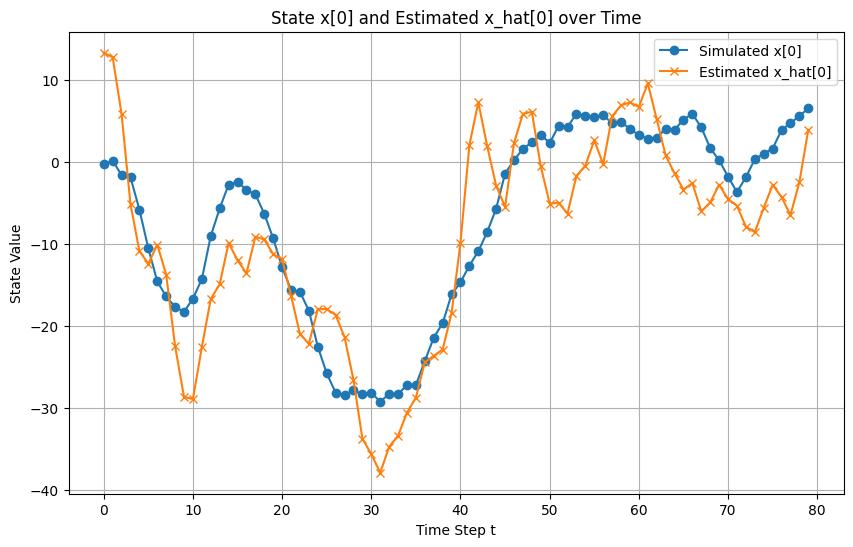

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[1] and Estimated x_hat[1] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

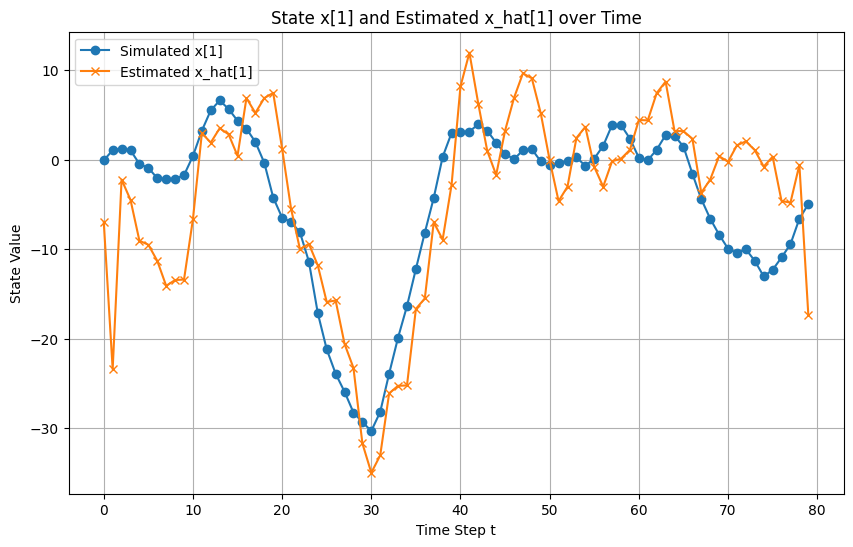

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[2] and Estimated x_hat[2] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

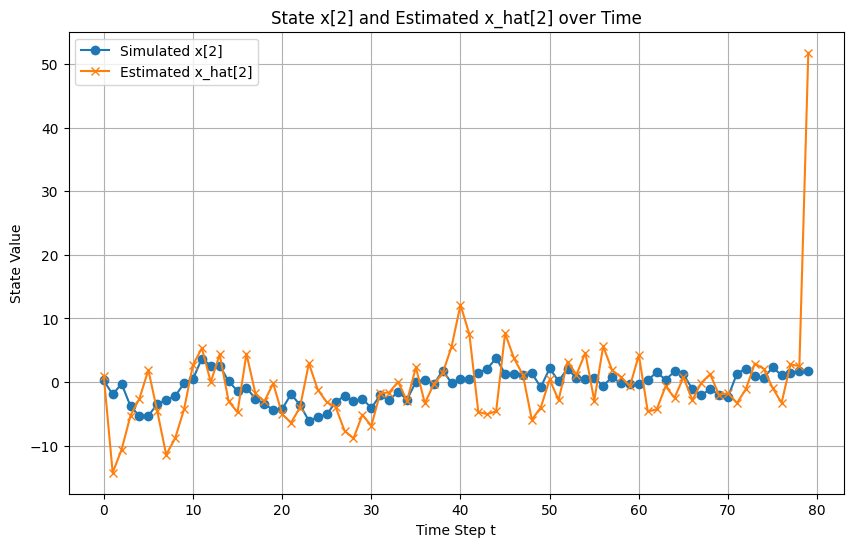

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[3] and Estimated x_hat[3] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

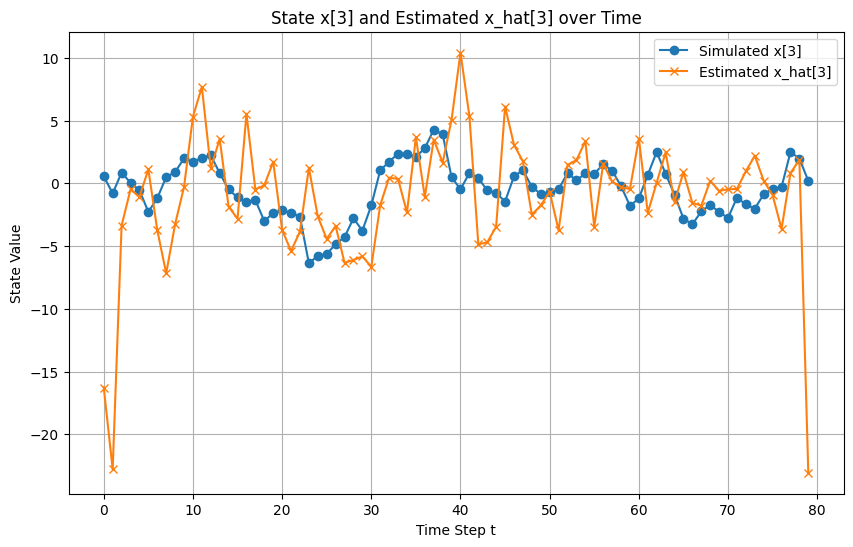

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume x and x_hat are loaded or computed already and are numpy arrays
T = len(x_hat)  # Correct to define T based on the length of x_hat
t = np.arange(T)  # Time vector

# Ensure x_hat is a proper numpy array for slicing
x_hat = np.array(x_hat)  # Ensuring it's numpy array
x = np.array(x)  # Ensuring x is also a numpy array

# Loop through each state component for plotting
for i in range(x.shape[1]):  # This assumes x is 2D (time steps, state variables)
    plt.figure(figsize=(10, 6))

    # Plot simulated state (including all states)
    plt.plot(t, x[1:, i], label=f'Simulated x[{i}]', marker='o')

    # Plot estimated state (ensure x_hat matches dimensions)
    plt.plot(t, x_hat[:, i], label=f'Estimated x_hat[{i}]', marker='x')

    plt.title(f'State x[{i}] and Estimated x_hat[{i}] over Time')
    plt.xlabel('Time Step t')
    plt.ylabel('State Value')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1000x700 with 0 Axes>

Text(-0.21155296437105847, -0.593157353970133, 't = 1')

Text(6.519645227986616, -4.982076078299024, 't = 80')

Text(0.5, 0, '$(x_t)_1$')

Text(0, 0.5, '$(x_t)_2$')

Text(0.5, 1.0, 'Measurements and True Positions')

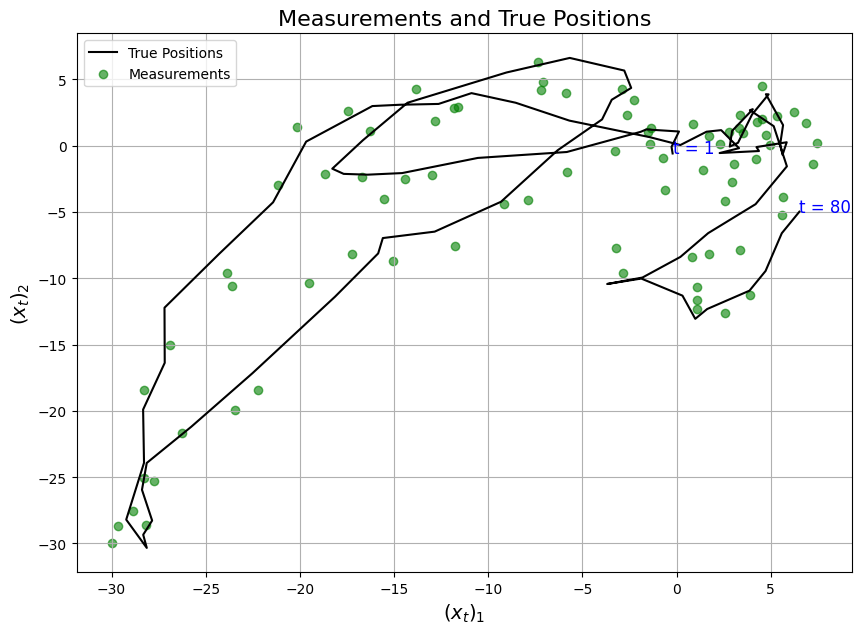

In [ ]:
# Generate the graph for Measurements and True Positions based on the computed values

plt.figure(figsize=(10, 7))

# Extracting the first two dimensions for plotting (2D plot)
true_positions = x_array[:, :2]  # True states (first two state variables)
measurements = y.reshape(T, -1)[:, :2]  # Observations (measurements) in the same dimensions

# Plot the true positions as a continuous line
plt.plot(true_positions[:, 0], true_positions[:, 1], 'k-', label='True Positions')

# Plot the measurements as scattered points
plt.scatter(measurements[:, 0], measurements[:, 1], color='green', alpha=0.6, label='Measurements')

# Annotate start and end points
plt.text(true_positions[0, 0], true_positions[0, 1], 't = 1', fontsize=12, color='blue')
plt.text(true_positions[-1, 0], true_positions[-1, 1], f't = {T}', fontsize=12, color='blue')

# Add labels, title, and legend
plt.xlabel(r'$(x_t)_1$', fontsize=14)
plt.ylabel(r'$(x_t)_2$', fontsize=14)
plt.title('Measurements and True Positions', fontsize=16)
plt.legend()
plt.grid()

# Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'Control Input Value $u$')

Text(0.5, 1.0, 'Control Input $u$ and Estimated Control Input $u_{hat}$ over Time')

Text(0, 0.5, 'Control Input Value $u_{hat}$')

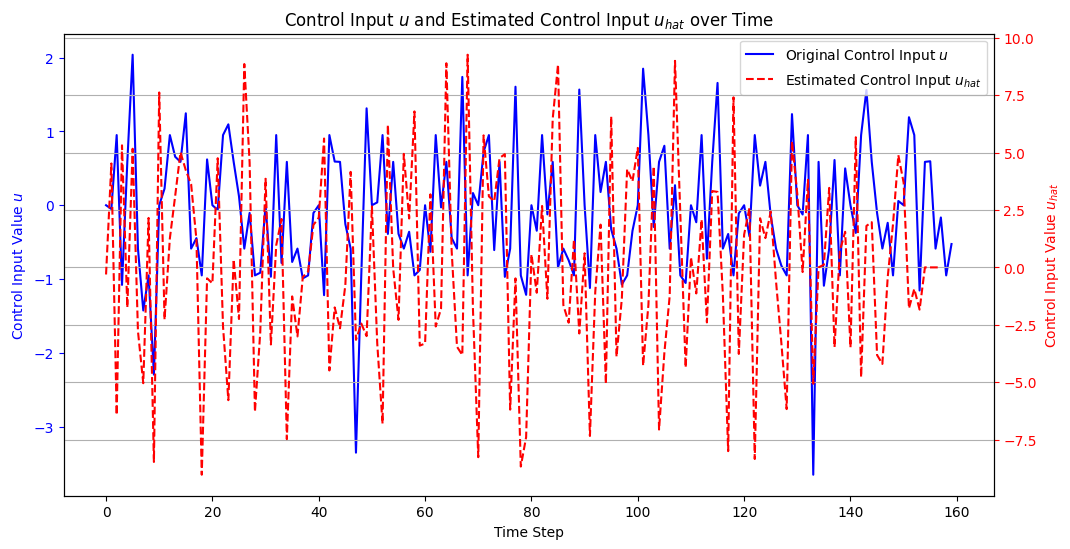

In [ ]:
import matplotlib.pyplot as plt

# Assuming `u` and `u_hat` are numpy arrays of the correct shape
# You can reshape or flatten `u_hat` as required before this step
u_hat_flattened = u_hat.flatten()
u=u.flatten()

# Creating a new figure
plt.figure(figsize=(12, 6))

# Create the primary y-axis for the original control input
ax1 = plt.gca()
ax1.plot(u, 'b-', label='Original Control Input $u$')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Control Input Value $u$', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Control Input $u$ and Estimated Control Input $u_{hat}$ over Time')

# Create a secondary y-axis for the estimated control input if necessary
ax2 = ax1.twinx()
ax2.plot(u_hat_flattened, 'r--', label='Estimated Control Input $u_{hat}$')
ax2.set_ylabel('Control Input Value $u_{hat}$', color='r')
ax2.tick_params('y', colors='r')

# Adding the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Comparison of Centered Half Atil @ z - btil Values and Corresponding Half v Values')

Text(0.5, 0, 'Time Steps')

Text(0, 0.5, 'Centered Values')

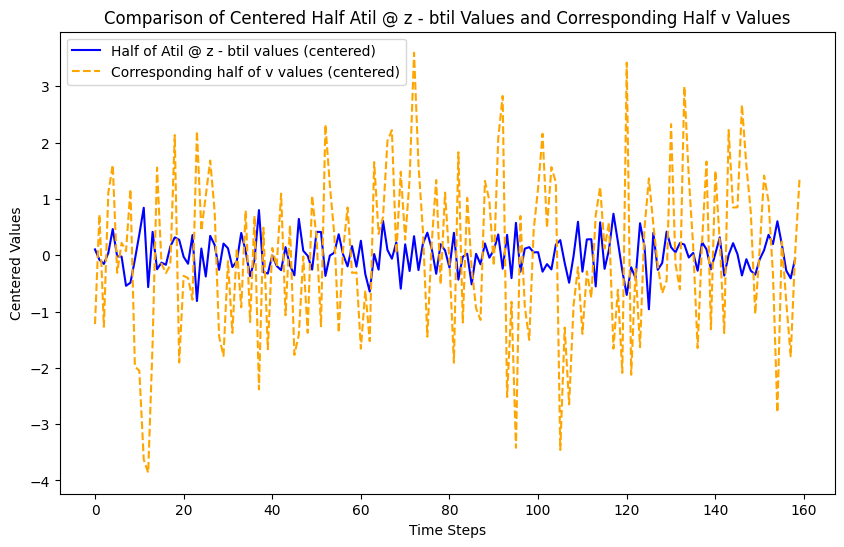

In [ ]:
k = Atil @ z - btil
half_k = k[:len(k) // 2]




half_v = np.array(v[:len(half_k)]).reshape(-1, 1)

# Normalize both datasets to have zero mean
half_k_centered = half_k - np.mean(half_k)
half_v_centered = half_v - np.mean(half_v)

# Now let's plot the centered half u values and corresponding half v values
plt.figure(figsize=(10, 6))
plt.plot(half_k_centered, label='Half of Atil @ z - btil values (centered)', linestyle='-', color='blue')
plt.plot(half_v_centered, label='Corresponding half of v values (centered)', linestyle='--', color='orange')
plt.title('Comparison of Centered Half Atil @ z - btil Values and Corresponding Half v Values')
plt.xlabel('Time Steps')
plt.ylabel('Centered Values')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Error between Simulated State x[0] and Estimated State x_hat[0] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'Error Value')

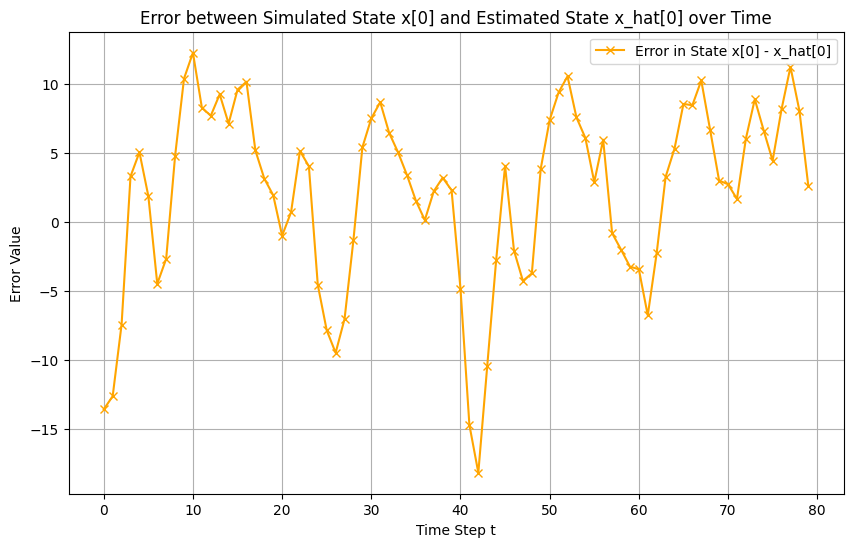

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Error between Simulated State x[1] and Estimated State x_hat[1] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'Error Value')

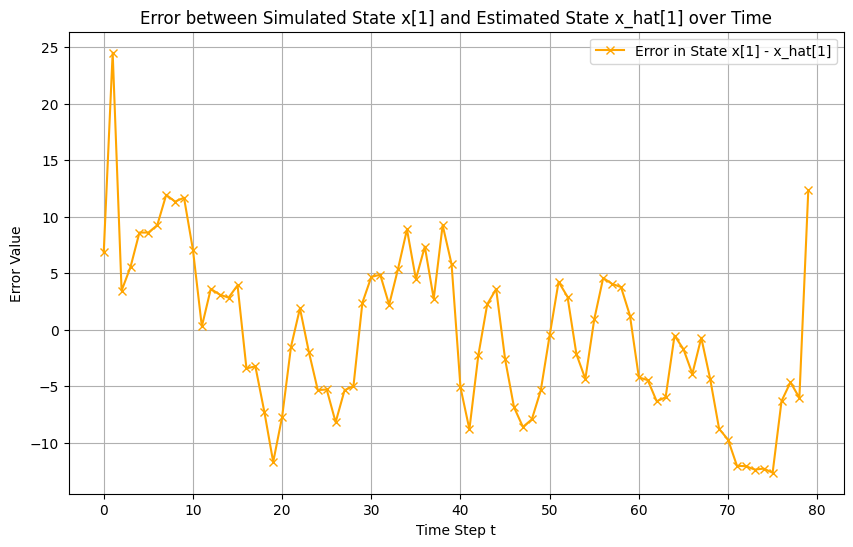

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Error between Simulated State x[2] and Estimated State x_hat[2] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'Error Value')

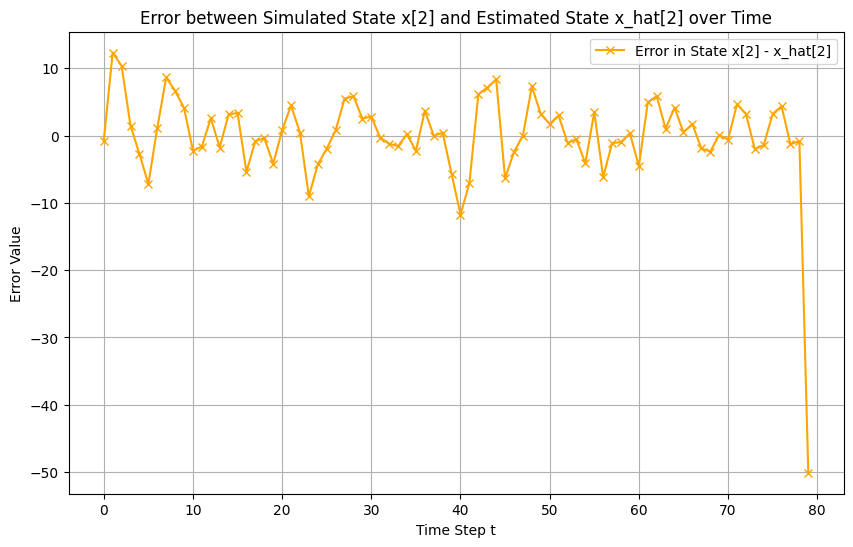

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Error between Simulated State x[3] and Estimated State x_hat[3] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'Error Value')

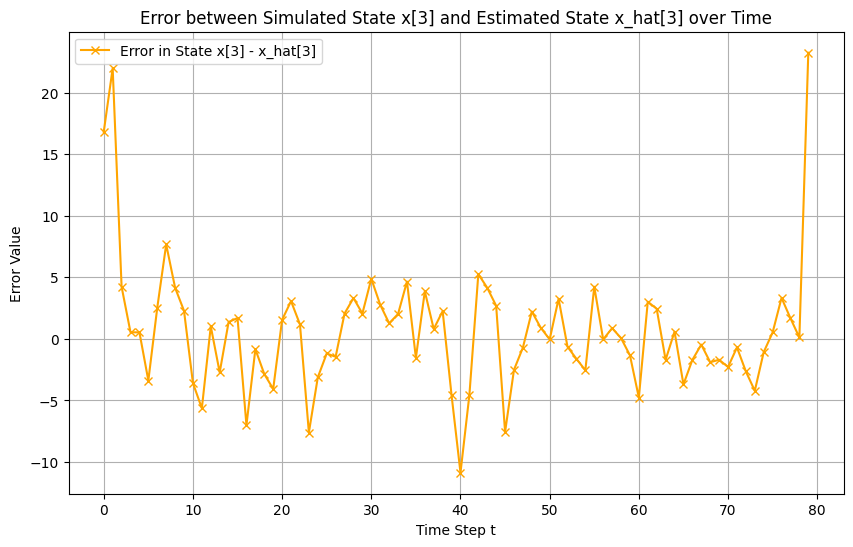

In [ ]:
# Reshape x_hat to remove the last dimension if it's (80, 4, 1)
x_hat = np.array(x_hat).squeeze()  # Removes any singleton dimensions

# Calculate the error (difference) between x and x_hat
error = np.array(x[1:]) - x_hat  # Now both should be of shape (80, 4)

# Plot the error for each state component
T = error.shape[0]  # Time steps based on error length
t = np.arange(T)  # Time vector

# Loop through each state component for plotting error
for i in range(error.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(t, error[:, i], label=f'Error in State x[{i}] - x_hat[{i}]', marker='x', color='orange')
    plt.title(f'Error between Simulated State x[{i}] and Estimated State x_hat[{i}] over Time')
    plt.xlabel('Time Step t')
    plt.ylabel('Error Value')
    plt.legend()
    plt.grid(True)
    plt.show()
